In [1]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# pip install torchsummary

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# 데이터셋 인스턴스 생성
data = pd.read_csv('https://raw.githubusercontent.com/Kim-TaeWook/AI-class/refs/heads/main/week6/diabetes.csv')  # CSV 파일 경로

In [4]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


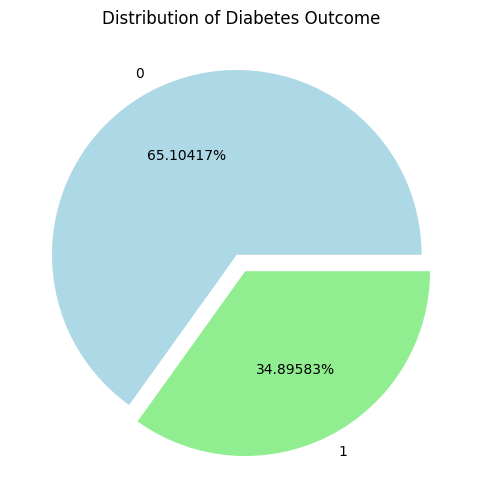

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# Outcome 컬럼으로 접근
data["Outcome"].value_counts().plot(
    kind='pie',
    autopct='%0.05f%%',
    colors=['lightblue', 'lightgreen'],
    explode=(0.05, 0.05)
)

plt.title("Distribution of Diabetes Outcome")
plt.ylabel("")  # 라벨 없애기
plt.show()

In [6]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# --- 시퀀스 형식으로 변환 위해 데이터와 타겟 합치기 ---
# 원래 X는 (n_samples, 8)이고, y는 (n_samples,), 
# hstack 후 data_array는 (n_samples, 9)
data_array = np.hstack((X, y.reshape(-1, 1)))
print("data_array.shape:", data_array.shape)

data_array.shape: (768, 9)


In [9]:
# --- Split sequences function: n_steps=5 ---
def split_sequences(sequences, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :-1]  # 모든 열 중 마지막(타겟 제외)
        seq_y = sequences[end_ix-1, -1]     # 마지막 행의 Outcome (타겟)
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

n_steps = 5
X_seq, y_seq = split_sequences(data_array, n_steps)
print("After sequence split: X_seq.shape:", X_seq.shape, "y_seq.shape:", y_seq.shape)
# X_seq.shape will be (n_new_samples, 5, 8) and y_seq.shape will be (n_new_samples,)

After sequence split: X_seq.shape: (764, 5, 8) y_seq.shape: (764,)


In [10]:
# --- 학습/테스트 데이터 분할 ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)
print("Train:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)

Train: (611, 5, 8) (611,) Test: (153, 5, 8) (153,)


In [11]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [12]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([611, 5, 8]),
 torch.Size([153, 5, 8]),
 torch.Size([611]),
 torch.Size([153]))

## **모델 정의**

In [14]:
# 모델 정의
class DiabetesCNN(nn.Module):
    def __init__(self):
        super(DiabetesCNN, self).__init__()
        # 각 시퀀스의 길이 n_steps=5, 피처 수 = 8 → 입력 shape (batch, 8, 5)
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Conv1d 계층: 시퀀스 길이 5 유지
        self.fc1 = nn.Linear(32 * 5, 64)
        # 출력 노드를 1로 설정 (BCEWithLogitsLoss를 사용하기 위함)
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # 출력: 단일 로짓 값
        return x

model = DiabetesCNN()
# summary expects input shape: (channels, sequence_length)
summary(model, input_size=(8, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             400
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 1]              65
Total params: 12,337
Trainable params: 12,337
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


## **손실 함수 및 최적화 기법 정의**

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **모델 학습**

In [16]:
# 학습 변수 초기화
train_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # 현재 inputs shape: (batch, n_steps, features) i.e. (batch, 5, 8)
        # CNN 입력으로 사용하기 위해 (batch, channels, sequence_length)
        inputs = inputs.permute(0, 2, 1)  # → (batch, 8, 5)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs shape: (batch, 1)
        # BCEWithLogitsLoss: labels must be of shape (batch, 1) and float type
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    avg_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(avg_loss)
    
    # 평가 단계
    model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_dataloader:
        # 평가 시에도 permute 잊지 않기
        inputs = inputs.permute(0, 2, 1)
        outputs = model(inputs)  # (batch, 1)
        # 예측: sigmoid를 사용하여 0과 1로 분류
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        total += labels.size(0)
        correct += (preds.squeeze(1) == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6704, Accuracy: 62.75%
Epoch 2/20, Loss: 0.6399, Accuracy: 62.75%
Epoch 3/20, Loss: 0.6136, Accuracy: 62.75%
Epoch 4/20, Loss: 0.5710, Accuracy: 71.24%
Epoch 5/20, Loss: 0.5133, Accuracy: 74.51%
Epoch 6/20, Loss: 0.4718, Accuracy: 73.86%
Epoch 7/20, Loss: 0.4441, Accuracy: 74.51%
Epoch 8/20, Loss: 0.4192, Accuracy: 73.20%
Epoch 9/20, Loss: 0.4039, Accuracy: 75.16%
Epoch 10/20, Loss: 0.3960, Accuracy: 77.12%
Epoch 11/20, Loss: 0.3682, Accuracy: 73.86%
Epoch 12/20, Loss: 0.3498, Accuracy: 73.86%
Epoch 13/20, Loss: 0.3402, Accuracy: 75.82%
Epoch 14/20, Loss: 0.3217, Accuracy: 73.20%
Epoch 15/20, Loss: 0.3019, Accuracy: 72.55%
Epoch 16/20, Loss: 0.2896, Accuracy: 70.59%
Epoch 17/20, Loss: 0.2732, Accuracy: 69.93%
Epoch 18/20, Loss: 0.2641, Accuracy: 71.24%
Epoch 19/20, Loss: 0.2541, Accuracy: 71.24%
Epoch 20/20, Loss: 0.2352, Accuracy: 72.55%
Training complete.


## **모델 평가**

In [17]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.permute(0, 2, 1)  # (batch, 8, 5)
        outputs = model(inputs)
        # 예측: sigmoid -> threshold (0.5)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions).flatten()

conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[73 23]
 [19 38]]
F1 Score: 0.73
Precision: 0.73
Recall: 0.73


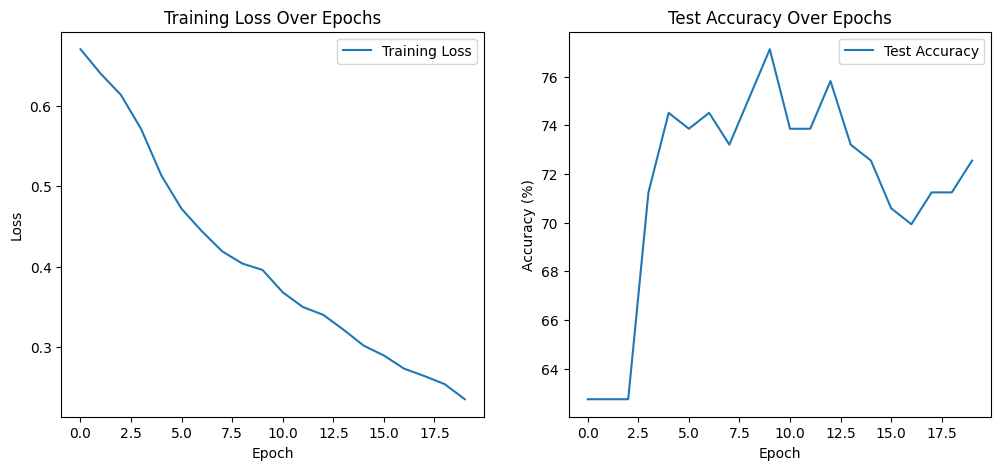

In [18]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()